<a href="https://colab.research.google.com/github/janchorowski/ml_uwr/blob/fall2020/assignment3/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Assignment 3

**Submission deadline:**
* **Regular problems: last lab session before or on Monday, 04.12.20**
* **Bonus problems: deadline for Lab Assignment 4**

**Points: 10 + 7 bonus points**


In [ ]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport

In [ ]:
# Standard IPython notebook imports
%matplotlib inline

import os
from io import StringIO

import graphviz
import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sstats
import seaborn as sns
import sklearn.ensemble
import sklearn.tree
from tqdm import tqdm_notebook
from tqdm import tqdm

# In this way we can import functions straight from github
with httpimport.github_repo(
    "janchorowski", "nn_assignments", module="common", branch="nn18"
):
    from common.plotting import plot_mat

sns.set_style("whitegrid")


In [ ]:
# @title Data Loading
# We will load a few commonly used datasets:
# - mushroom
# - iris
# - adult
# - congressional voting
# - german credit


# 1. Mushroom dataset
# https://archive.ics.uci.edu/ml/datasets/mushroom
# only categorical attributes with missing values
columns = [
    "target",
    "cap-shape",
    "cap-surface",
    "cap-color",
    "bruises?",
    "odor",
    "gill-attachment",
    "gill-spacing",
    "gill-size",
    "gill-color",
    "stalk-shape",
    "stalk-root",
    "stalk-surface-above-ring",
    "stalk-surface-below-ring",
    "stalk-color-above-ring",
    "stalk-color-below-ring",
    "veil-type",
    "veil-color",
    "ring-number",
    "ring-type",
    "spore-print-color",
    "population",
    "habitat",
]

# Use read_csv to load the data.
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
mushroom_df = pd.read_csv(url, header=None, names=columns)
mushroom_idx_df = mushroom_df.reset_index()

# 2. Iris
iris_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris_df = pd.read_csv(
    iris_url,
    header=None,
    names=["sepal_length", "sepal_width", "petal_length", "petal_width", "target"],
)

# 3. Congressoinal Voting
# Binary attributes, binary class, missing data
vote_df = (
    pd.read_csv(
        "https://pkgstore.datahub.io/machine-learning/vote/vote_csv/data/65f1736301dee4a2ad032abfe2a61acb/vote_csv.csv"
    )
    .rename({"Class": "target"}, axis=1)
    .fillna("na")
)

# 4. Adult
# census records, continuous and categorical attributes (some ordered), missing values
adult_names = [
    "Age",
    "Workclass",
    "fnlwgt",
    "Education",
    "Education-Num",
    "Martial Status",
    "Occupation",
    "Relationship",
    "Race",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "target",
]
adult_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=adult_names,
    header=None,
    na_values="?",
)
adult_test_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
    names=adult_names,
    header=None,
    na_values="?",
    skiprows=1,
)

# 5. German Credit

german_df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data",
    names=[f"A{d}" for d in range(1, 21)] + ["target"],
    header=None,
    sep=" ",
)

# Problem 1 [2p] 

Download a categorical dataset, such as the [mushroom](https://archive.ics.uci.edu/ml/datasets/mushroom) from UCI and try to find the most predictive variables: 

### Implement mutual information [1p]

Implement the function `entropy` to compute the entropy of a columnt of the dataset.

The [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) of a discrete variable is defined to be:

$$H(X) = -\sum_x p_X(x) \log_2 p_X(x).$$

A good in tutorial is given by Chris Olah: https://colah.github.io/posts/2015-09-Visual-Information/.


When $X$ is a discrete random variables, we can estimate the probabilities with counts:

$$p_X(x) = \frac{\text{number of instances where }X=x}{\text{total number of instances}}.$$


Hint: the following `pandas` functions may be useful:
- `count`
- `value_count`

Then use the datafranme's `apply` function to compute the entropy of all columns.

In [ ]:
mushroom_df.describe()

,target,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [ ]:
def entropy_series(series):
    return -np.sum(series.value_counts() / series.count() * np.log2(series.value_counts() / series.count()))

mushroom_df.apply(entropy_series, axis = 0)

target                      0.999068
cap-shape                   1.652889
cap-surface                 1.575486
cap-color                   2.510143
bruises?                    0.979327
odor                        2.319414
gill-attachment             0.173129
gill-spacing                0.637878
gill-size                   0.892256
gill-color                  3.030433
stalk-shape                 0.986927
stalk-root                  1.822922
stalk-surface-above-ring    1.221348
stalk-surface-below-ring    1.399135
stalk-color-above-ring      1.936809
stalk-color-below-ring      1.978163
veil-type                  -0.000000
veil-color                  0.196238
ring-number                 0.420680
ring-type                   1.535121
spore-print-color           2.203227
population                  2.003398
habitat                     2.274747
dtype: float64

Implement the conditional entropy computation

$$H(Y|X) = \sum_x p_X(x) H(Y|x) = \sum_x p_X(x) \sum_y p_Y(y|x) \log_2 p_Y(y|x)$$

Hint 1: the above formula can be computed as follows:
1. split the data by the values of $X$
2. for each value $x$ that $X$ takes, compute the entropy of $Y$
3. average the entropies, weighting them by how frequent the $x$ value ocurred.

Hint 2: helpful pandas constructs are:
- `groupby` and `agg`
- you can aggregate a grouping using your own custom functions


In [ ]:
def cond_entropy(df: pd.DataFrame, Y, X):
    """Compute the conditional H(Y|X) in dataframe df
    Args:
        df: a dataframe
        X: the name of the conditioning columt
        Y: the name of the column whose entropy we wish to compute
    """
    res = 0
    unique_vals = df[X].unique()
    grouped_by_X = df.groupby(by = X)
    counts = df[X].value_counts()
    count = df[X].count()
    for value in unique_vals:
        prob_of_value = counts[value] / count
        entropy_of_Y = entropy_series(grouped_by_X.get_group(value)[Y])
        res += prob_of_value * entropy_of_Y
    return res


In [ ]:
# Now for each column C compute the conditional entropy H(target|C)
# Which variable tells us the most about the target

for column in mushroom_df.columns:
    if column != 'target':
        print(f"{column}: {cond_entropy(mushroom_df, 'target', column)}")

cap-shape: 0.9502711949370873
cap-surface: 0.9704776640986876
cap-color: 0.9630186138962565
bruises?: 0.8066884111112408
odor: 0.0929929194884606
gill-attachment: 0.9849028696218441
gill-spacing: 0.8981847128758901
gill-size: 0.7689135217244143
gill-color: 0.5820903734563291
stalk-shape: 0.9915511243027961
stalk-root: 0.8642502592451847
stalk-surface-above-ring: 0.7143422976539759
stalk-surface-below-ring: 0.7271734234797138
stalk-color-above-ring: 0.7452227234102206
stalk-color-below-ring: 0.7576523303448939
veil-type: 0.9990678968724603
veil-color: 0.9752508807515436
ring-number: 0.9606152276293699
ring-type: 0.6810463860789229
spore-print-color: 0.518362979187545
population: 0.797109877805608
habitat: 0.8422342922673683


Based on the conditional entropy, odor tells us the most about the target. 

### Implement infogain ratio [1p]
Add an ID column, that assigns a unique ID to each observation (row). Compute the mutual information between target and ID. How to interpret the results? Do you think the ID is important in predicting the target? Devise a measure similar to Information Gain Ratio from C4.5 and show its variable ranking.



In [ ]:
mushroom_with_id = mushroom_df.copy()
mushroom_with_id.insert(loc = 0, column = 'ID', value = [i for i in range(0, mushroom_with_id.shape[0])])

In [ ]:
mushroom_with_id.head()

,ID,target,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [ ]:
# I(target, ID) = H(ID) - H(ID, target)
print(f"{entropy_series(mushroom_with_id['ID']) - cond_entropy(mushroom_with_id, 'ID', 'target'):.6f}")

0.999068


In [ ]:
# I(target, ID) = H(target) - H(target, ID)
print(f"{entropy_series(mushroom_with_id['target']) - cond_entropy(mushroom_with_id, 'target', 'ID'):.6}")

0.999068


Mutual information is equal to entropy of 'target'.
<br/>
If we calculate H(target, ID), we can see that the inner sum of this formula:
$$\sum_x p_{ID}(x) \sum_y p_{target}(y|x) \log_2 p_{target}(y|x)$$
is always equal to 0 (entropy of a random variable that can only have one value is 0). <br/>
Therefore, if we subtract H(target, ID) from H(target), we end up with H(target) as the value of mutual information. <br/>
Every row's ID is unique, so knowing the value of ID unambiguously tells us what is the target. <br/>
ID predicts the target for training data but it's useless for predicting the target on any data from outside the training set. 

In [ ]:
for column in mushroom_with_id.columns:
    col_entropy = entropy_series(mushroom_with_id[column])
    mut_information = entropy_series(mushroom_with_id['target']) - cond_entropy(mushroom_with_id, 'target', column)
    if col_entropy == 0:
        col_entropy += 1e-30
    print(f"{column}: {mut_information / col_entropy}")

ID: 0.07692253284016984
target: 1.0
cap-shape: 0.02952206988590187
cap-surface: 0.01814692451164122
cap-color: 0.014361447780696823
bruises?: 0.19644043129956845
odor: 0.3906481565033008
gill-attachment: 0.0818178118172925
gill-spacing: 0.15815426132075966
gill-size: 0.25794648736352677
gill-color: 0.13759668648296522
stalk-shape: 0.007616338689020934
stalk-root: 0.07395690261310009
stalk-surface-above-ring: 0.2331240725567335
stalk-surface-below-ring: 0.19433046798651937
stalk-color-above-ring: 0.13106361757552198
stalk-color-below-ring: 0.12204028298851571
veil-type: 0.0
veil-color: 0.12136782986327024
ring-number: 0.09140595216694161
ring-type: 0.20716374427196194
spore-print-color: 0.21818217753240354
population: 0.10080772885489371
habitat: 0.0689455094456155


Value for ID is smaller than value for target because the entropy of ID is higher => information needed to specify the outcome is higher. 

# Problem 2: Decision Tree Implementation

Currently, there are no good implementations of Decision Trees in Python.

Sadly, the machine leading toolkit [sklearn](https://scikit-learn.org/stable/index.html) doesn't handle categorical attributes. Let's use this as an excuse to implement Decision Tress ourselves.



## Decision Tree Task 1: Purity Measures [1p]

Please fill the purity measures below.

Verify the correctness by plotting the purity values if a two-class set with given class probabilities

In [ ]:
def entropy(counts):
    return -np.sum(counts / counts.sum() * np.log2(counts / counts.sum() + 1e-100))

In [ ]:
def gini(counts):
    return 1 - np.sum((counts/counts.sum())**2)

In [ ]:
def mean_err_rate(counts):
    return 1 - np.max(counts) / counts.sum()

Text(0.5, 0, 'Class balance')

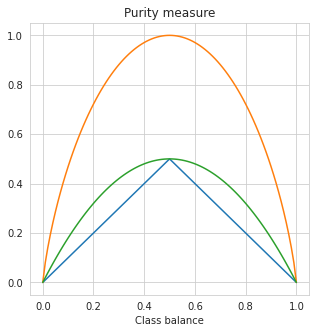

In [ ]:
# Make a plot of the purity functions

plt.figure(figsize = (5,5))
fractions = np.linspace(0, 1, 101)
err_rates = [mean_err_rate(np.array([f, 1.0-f])) for f in fractions]
entropy_vals = [entropy(np.array([f, 1.0-f])) for f in fractions]
gini_vals = [gini(np.array([f, 1.0-f])) for f in fractions]
plt.plot(fractions, err_rates)
plt.plot(fractions, entropy_vals)
plt.plot(fractions, gini_vals)
plt.title("Purity measure")
plt.xlabel("Class balance")

## Decision Tree Task 2: Categorical Splits [1p]

### The anatomy of a Decision Tree


All internal (non-leaf) nodes of a split training examples according to a test implemented by the node. We capture this behavior using a generic `AbstractSplit` class which implements a split of data contained in the dataframe `df` using the attribute `attr`.

The class features a lightweight constructor, `__init__` which only saves the information required to later split a training dataframe and recursively build the subtrees using the `build_subtrees` method.

Fill in the blanks in the code below, as indicated by the TODO comments.

In [ ]:
class AbstractSplit:
    """Split the examples in a tree node according to a criterion.
    """

    def __init__(self, attr):
        self.attr = attr
        self.purity_gain = None 

    def __call__(self, x):
        """Return the subtree corresponding to x."""
        raise NotImplementedError

    def build_subtrees(self, df, subtree_kwargs):
        """Recuisively build the subtrees."""
        raise NotImplementedError

    def iter_subtrees(self):
        """Return an iterator over subtrees."""
        raise NotImplementedError

    def add_to_graphviz(self, dot):
        """Add the split to the graphviz vizalization."""
        raise NotImplementedError

    def get_purity_gain(self):
        return self.purity_gain

    def __str__(self):
        return f"{self.__class__.__name__}: {self.attr}"

We will first implement a Multivariate Categorical split which has a subtree for each value that an attribute may take.

In [ ]:
class CategoricalMultivalueSplit(AbstractSplit):
    def build_subtrees(self, df, subtree_kwargs):
        self.subtrees = {}
        for group_name, group_df in df.groupby(self.attr):
            child = Tree(group_df, **subtree_kwargs)
            self.subtrees[group_name] = child

    def __call__(self, x):
        # Return the subtree for the given example
        if x[self.attr] in self.subtrees.keys():
            return self.subtrees[x[self.attr]]
        else:
            return "NOT_HANDLED"
    
    def iter_subtrees(self):
        # self.subtrees is a dictionary - group_name: child
        return self.subtrees.values()

    def add_to_graphviz(self, dot, parent, print_info):
        for split_name, child in self.subtrees.items():
            child.add_to_graphviz(dot, print_info)
            dot.edge(f"{id(parent)}", f"{id(child)}", label=f"{split_name}")

In [ ]:
def get_categorical_split_and_purity(
    df, parent_purity, purity_fun, attr, normalize_by_split_entropy=False
):
    """Return a multivariate split and its purity.
    Args:
        df: a dataframe
        parent_purity: purity of the parent node
        purity_fun: function to compute the purity
        attr: attribute over whihc to split the dataframe
        normalize_by_split_entropy: if True, divide the purity gain by the split
            entropy (to compute https://en.wikipedia.org/wiki/Information_gain_ratio)
    
    Returns:
        pair of (split, purity_gain)
    """
    split = CategoricalMultivalueSplit(attr)
    # Compute the purity after the split
    mean_child_purity= np.sum([purity_fun(group_df['target'].value_counts()) * group_df['target'].count()
                               for group_name, group_df in df.groupby(attr)]) / df['target'].count()  # cond_entropy(df, 'target', attr)  
        
    # Note: when purity is measured by entropy, this corresponds to Mutual Information
    purity_gain = parent_purity - mean_child_purity
    if normalize_by_split_entropy:
        purity_gain /= entropy(df[attr].value_counts())
    split.purity_gain = purity_gain
    split.mean_child_purity = mean_child_purity
    return split, purity_gain 

In [ ]:
def get_split(df, criterion="infogain", nattrs=None):
    """Find best split on the given dataframe.
    
    Attributes:
        - df: the dataframe of smaples in the node to be split
        - criterion: spluis selection criterion
        - nattrs: flag to randomly limit the number of considered attributes. Used 
          in random tree impementations.

    Returns:
        - If no split exists, return None.
        - If a split exists, return an instance of a subclass of AbstractSplit
    """
    # Implement termination criteria:
    # TermCrit1: Node is pure
    target_value_counts = df["target"].value_counts()
    if len(target_value_counts) == 1:
        return None
    # TermCrit2: No split is possible
    #    First get a list of attributes that can be split
    #    (i.e. attribute is not target and atribute can take more than one value)
    #
    #    The list of attributes on which we can split will also be handy for building random trees.
    #    possible_splits must be a list
    possible_splits = [attribute for attribute in df.columns if (attribute != 'target'
                                                                and len(df[attribute].value_counts()) != 1)]  
                                                                
    assert "target" not in possible_splits
    #    Terminate early if none are possivle
    if not possible_splits:
        return None

    # Get the base purity measure and the purity function
    if criterion in ["infogain", "infogain_ratio"]:
        purity_fun = entropy
    elif criterion in ["mean_err_rate"]:
        purity_fun = mean_err_rate
    elif criterion in ["gini"]:
        purity_fun = gini
    else:
        raise Exception("Unknown criterion: " + criterion)
    base_purity = purity_fun(target_value_counts)

    best_purity_gain = -1
    best_split = None

    # Random Forest support
    # restrict possible_splits to a few radomly selected attributes
    if nattrs is not None and nattrs <= len(possible_splits):
        n = len(possible_splits)
        possible_splits = np.random.choice(possible_splits, size = min(n, nattrs), replace = False)
    
    for attr in possible_splits:
        if np.issubdtype(df[attr].dtype, np.number):
            # Handling of numerical attributes will be defined later, in a manner
            # similar to categorical ones
            split_sel_fun = get_numerical_split_and_purity
        else:
            split_sel_fun = get_categorical_split_and_purity
        split, purity_gain = split_sel_fun(
            df,
            base_purity,
            purity_fun,
            attr,
            normalize_by_split_entropy=criterion.endswith("ratio"),
        )

        if purity_gain > best_purity_gain:
            best_purity_gain = purity_gain
            best_split = split
    return best_split

We can now define a Tree class, which represents both a Decision Tree and its Nodes.

Each node saves its class distribution in the `counts` attribute and debug/visualization information in the `info` field. 

Leaf nodes have `split == None`, while internal nodes have a split which points to subtrees.


In [ ]:
class Tree:
    def __init__(self, df, **kwargs):
        super().__init__()
        # Assert that threre are no missing values,
        # TODO: remove this for bonus problem #2.4
        assert not df.isnull().values.any()

        # Technicality:
        # We need to let subtrees know about all targets to properly color nodes
        # We pass this in subtree arguments.
        if "all_targets" not in kwargs:
            kwargs["all_targets"] = sorted(df["target"].unique())
        # Save keyword arguments to build subtrees
        kwargs_orig = dict(kwargs)
 
        # Get kwargs we know about, remaning ones will be used for splitting
        self.all_targets = kwargs.pop("all_targets")

        # Save debug info for visualization
        # Debugging tip: contents of self.info are printed in tree visualizations!
        self.counts = df["target"].value_counts()
        self.info = {
            "num_samples": len(df),
            "entropy": entropy(self.counts),
            "gini": gini(self.counts),
        }

        self.split = get_split(df, **kwargs)
        if self.split:
            self.split.build_subtrees(df, kwargs_orig)

    def get_target_distribution(self, sample):
        if self.split is None:
            return self.counts
        # TODO: descend into subtrees and return the leaf target distribution
        else:
            subtree = self.split(sample)
            if subtree == "NOT_HANDLED":
                return self.counts
            else:
                return self.split(sample).get_target_distribution(sample)
            
    def classify(self, sample):
        # TODO: classify the sample by descending into the appropriate subtrees.
        # Hint: you can also use self.get_target_distribution
        counts = self.get_target_distribution(sample)
        return counts.keys()[0]
        
    def draw(self, print_info=True):
        dot = graphviz.Digraph()
        self.add_to_graphviz(dot, print_info)
        return dot

    def add_to_graphviz(self, dot, print_info):
        freqs = self.counts / self.counts.sum()
        freqs = dict(freqs)
        colors = []
        freqs_info = []
        for i, c in enumerate(self.all_targets):
            freq = freqs.get(c, 0.0)
            if freq > 0:
                colors.append(f"{i%9 + 1};{freq}")
                freqs_info.append(f"{c}:{freq:.3f}")
        colors = ":".join(colors)
        labels = [" ".join(freqs_info)]
        if print_info:
            for k, v in self.info.items():
                labels.append(f"{k} = {v}")
        if self.split:
            labels.append(f"split by: {self.split.attr}")
        dot.node(
            f"{id(self)}",
            label="\n".join(labels),
            shape="box",
            style="striped",
            fillcolor=colors,
            colorscheme="set19",
        )
        if self.split:
            self.split.add_to_graphviz(dot, self, print_info)

#### Tree for criterion = entropy (infogain)


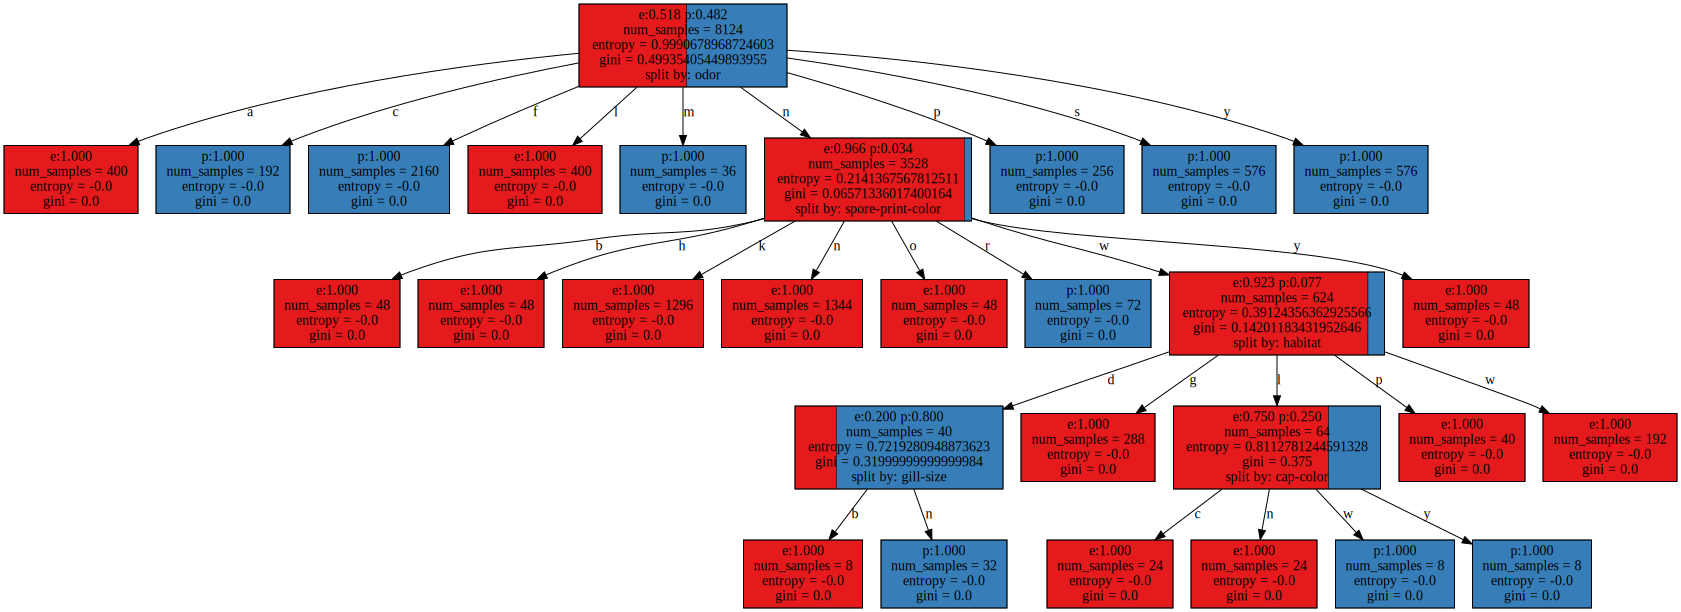

In [ ]:
# Train a Decision Tree on the mushroom data.
# Plot the tree using the `.draw()` method.

# Note: for this code to work you must fix the todos in the previous sections

mushroom_tree = Tree(mushroom_df)
mushroom_tree.draw()

#### Tree for criterion = gini

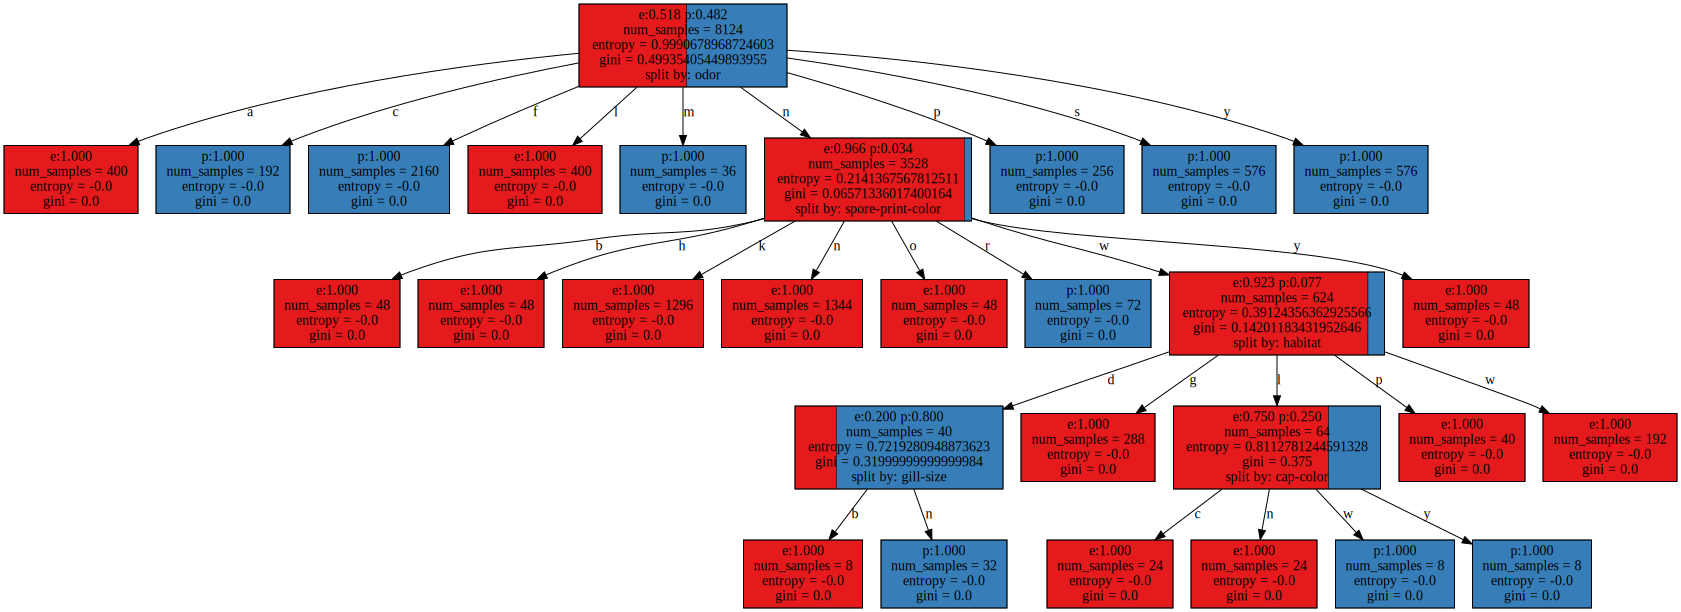

In [ ]:
mushroom_tree = Tree(mushroom_df, criterion = 'gini')
mushroom_tree.draw()

#### Tree for criterion = "mean_err_rate"


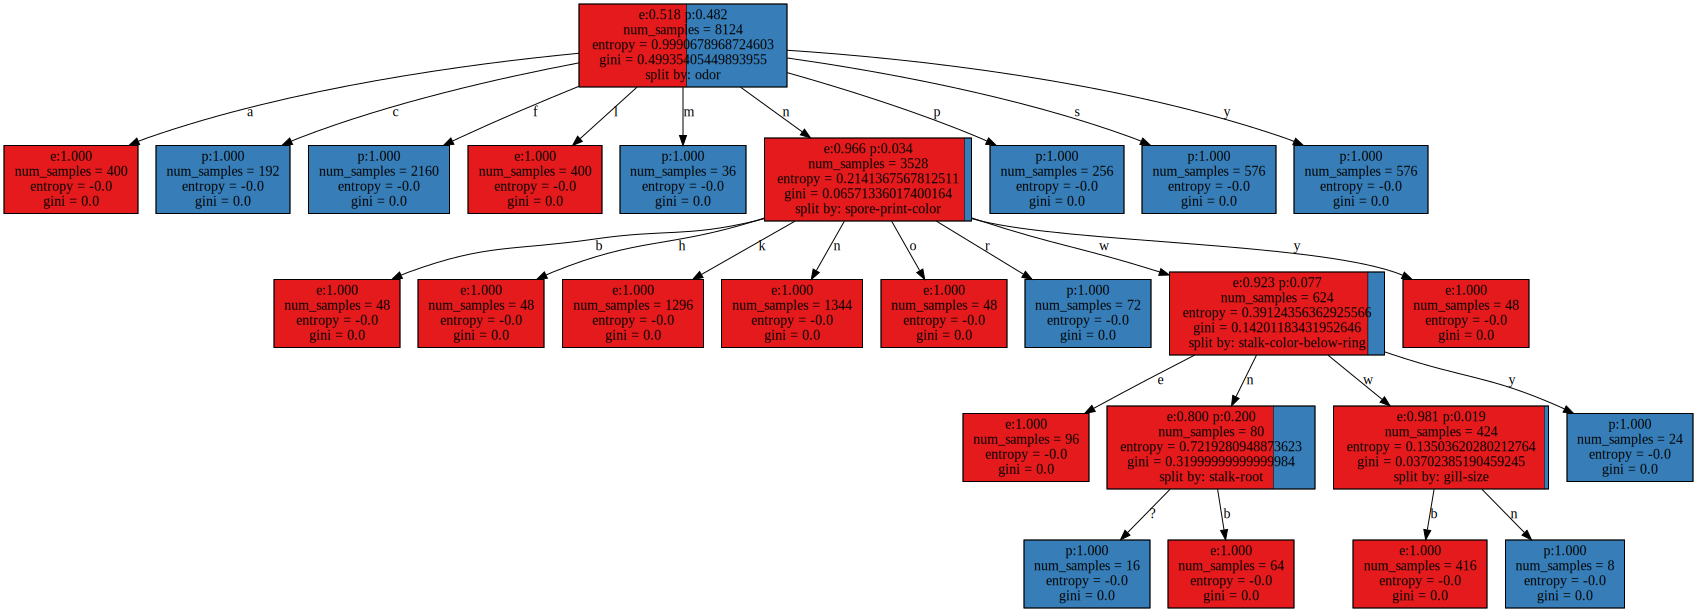

In [ ]:
mushroom_tree = Tree(mushroom_df, criterion = 'mean_err_rate')
mushroom_tree.draw()

#### Tree for infogain ratio

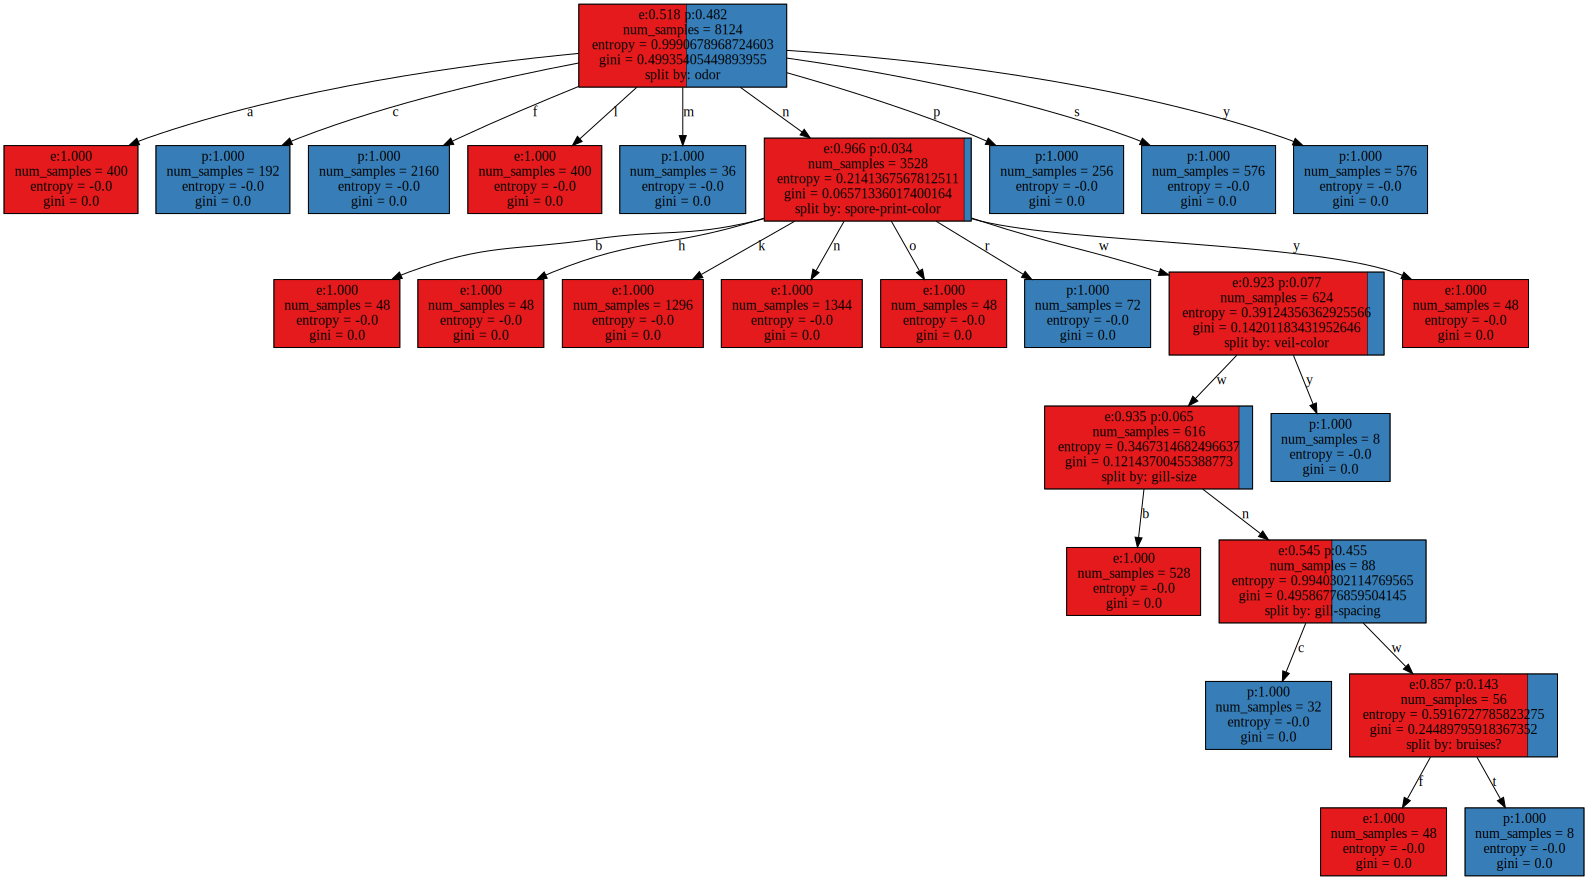

In [ ]:
mushroom_tree = Tree(mushroom_df, criterion = 'infogain_ratio')
mushroom_tree.draw()

#### Questions:


**Answer the questions below**
1. How many samples are classified correctly by a tree with only one split?
2. Is the tree different when different purity functions are used?


1. Tree with only one split classifies correctly about 8004 out of 8124 samples. 
2. Trees differ for different purity functions. For mean_err_rate splits on lower part of the tree are completely different than for gini or entropy.
Tree created using infogain ratio promotes splits that create less subtrees (differences also occur in the lower part of the tree).


## Decision Tree Task 3: Numerical Splits [1p]
A numerical split requires to search for the best threshold. Implement the selection of splits for numerical attributes below.

In [ ]:
class NumericalSplit(AbstractSplit):
    def __init__(self, attr, th):
        super(NumericalSplit, self).__init__(attr)
        self.th = th

    def build_subtrees(self, df, subtree_kwargs):
        self.subtrees = (
            Tree(df[df[self.attr] <= self.th], **subtree_kwargs),
            Tree(df[df[self.attr] > self.th], **subtree_kwargs),
        )

    def __call__(self, x):
        # return the sobtree for the data sample `x`
        if x[self.attr] <= self.th:
            return self.subtrees[0]
        else:
            return self.subtrees[1]


    def __str__(self):
        return f"NumericalSplit: {self.attr} <= {self.th}"

    def iter_subtrees(self):
        return self.subtrees

    def add_to_graphviz(self, dot, parent, print_info):
        self.subtrees[0].add_to_graphviz(dot, print_info)
        dot.edge(f"{id(parent)}", f"{id(self.subtrees[0])}", label=f"<= {self.th:.2f}")
        self.subtrees[1].add_to_graphviz(dot, print_info)
        dot.edge(f"{id(parent)}", f"{id(self.subtrees[1])}", label=f"> {self.th:.2f}")


def get_numerical_split_and_purity(
    df, parent_purity, purity_fun, attr, normalize_by_split_entropy=False
):
    """Find best split thereshold and compute the average purity after a split.
    Args:
        df: a dataframe
        parent_purity: purity of the parent node
        purity_fun: function to compute the purity
        attr: attribute over whihc to split the dataframe
        normalize_by_split_entropy: if True, divide the purity gain by the split
            entropy (to compute https://en.wikipedia.org/wiki/Information_gain_ratio)
    
    Returns:
        pair of (split, purity_gain)
    """
    attr_df = df[[attr, "target"]].sort_values(attr)
    targets = attr_df["target"]
    values = attr_df[attr]
    # Start with a split that puts all the samples into the right subtree
    right_counts = targets.value_counts()
    left_counts = right_counts * 0

    best_split = None  # Will be None, or NumericalSplit(attr, best_threshold)
    best_purity_gain = -1
    N = len(attr_df)
    for row_i in range(N - 1):
        # Update the counts of targets in the left and right subtree and compute
        # the purity of the split for all possible thresholds!
        # Return the best split found.

        # Remember that the attribute may have duplicate values and all samples
        # with the same attribute value must end in the same subtree!
        row_target = targets.iloc[row_i]
        attribute_value = values.iloc[row_i]
        next_attribute_value = values.iloc[row_i + 1]
        split_threshold = (attribute_value + next_attribute_value) / 2.0

        # Consider the split at threshold, i.e. NumericalSplit(attr, split_threshold)

        # the loop should return the best possible split.

        # TODO: update left_counts and right_counts
        left_counts[row_target] += 1
        right_counts[row_target] -= 1

        # The split is possible if attribute_value != next_attribute_value
        if attribute_value == next_attribute_value:
            continue

        # TODO: now consider the split at split_threshold and save it if it the best one
        mean_child_purity = ((purity_fun(left_counts) * left_counts.sum() + purity_fun(right_counts) * right_counts.sum()) /
                             (left_counts.sum() + right_counts.sum()))
        
        # Note: when purity is measured by entropy, this corresponds to Mutual Information
        purity_gain = parent_purity - mean_child_purity
        
        if normalize_by_split_entropy:
            purity_gain /= entropy(df[attr].value_counts())

        if purity_gain > best_purity_gain:
            best_split = NumericalSplit(attr, split_threshold)
            best_purity_gain = purity_gain
    best_split.purity_gain = best_purity_gain
    return best_split, best_purity_gain

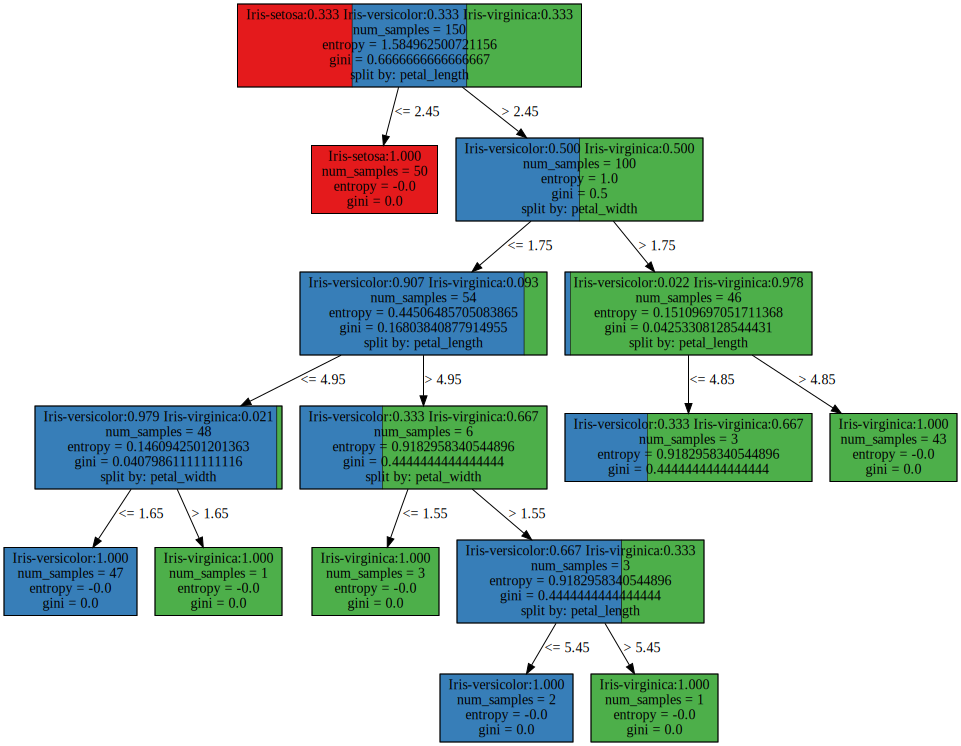

In [ ]:
# TODO: apply the tree to Iris with petal_length and petal_width attributes
iris2d = iris_df[["petal_length", "petal_width", "target"]]
iris_tree = Tree(iris2d)
iris_tree.draw()
#TODO: build and draw the tree


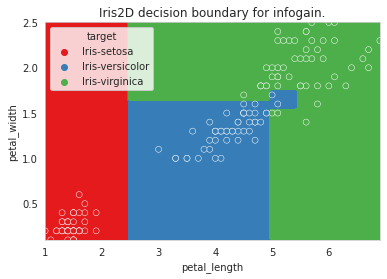

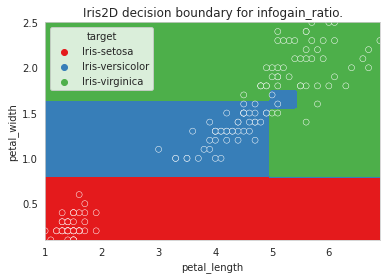

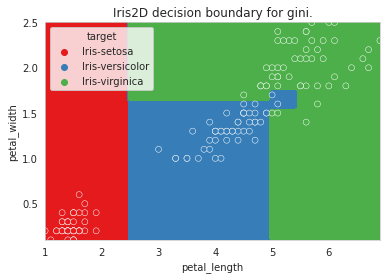

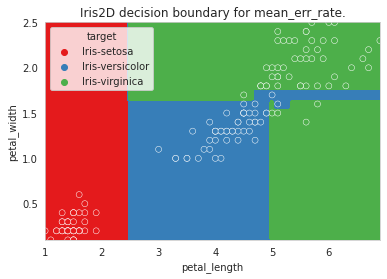

In [ ]:
# TODO: to verify the tree building algorithm draw Iris2D decision boundary
# for different splitting criteria.
mesh_x, mesh_y = np.meshgrid(
    np.linspace(iris2d.petal_length.min(), iris2d.petal_length.max(), 100),
    np.linspace(iris2d.petal_width.min(), iris2d.petal_width.max(), 100),
)

mesh_data = np.hstack([mesh_x.reshape(-1, 1), mesh_y.reshape(-1, 1)])
mesh_data = pd.DataFrame(mesh_data, columns=iris2d.columns[:-1])

preds = np.empty((len(mesh_data),))

for criterion in ["infogain", "infogain_ratio", "gini", "mean_err_rate"]:
    iris2d_tree = Tree(iris2d, criterion=criterion)
    for i, (_, r) in enumerate(mesh_data.iterrows()):
        preds[i] = iris2d_tree.all_targets.index(iris2d_tree.classify(r))

    plt.figure()
    plt.title(f"Iris2D decision boundary for {criterion}.")
    plt.contourf(
        mesh_x, mesh_y, preds.reshape(mesh_x.shape), cmap="Set1", vmin=0, vmax=7
    )
    sns.scatterplot(
        x="petal_length", y="petal_width", hue="target", data=iris_df, palette="Set1",
    )

## NOT SOLVED: Decision Tree Task 4: Handling missing data [2bp]

Implement support for missing values. A possible strategy does the following:
each time (both during training and testing) we encounter a split for which the smaple misses attribute's value, we a weighted copy of the sample down each subtree, with the weight equal to the probaiblity that the child subtree is selected (i.e. proportional to number of samples put into the subtree.).

##NOT SOLVED:  Decision Tree Task 5: Pruning [2-4bp]

Tree pruning tries to remove splits that don't result in a decrease of the error rate.

There are two possible strategies:

### 1. Reduced Error Rate Pruning
Build a tree using all the data. Then split the training set into 10 crossvalidation subsets. Then in a loop over the tesintg crossvalidation subset:
- put the data from the remaining 9 subsets through the tree, remember distributions at each node (leaf and internal nodes)
- classify the samples in the testing subset, record the error rate for all nodes 
- remove leaf nodes that have a higher error rate than their parents.

### 2. Confidence-interval Pruning
Build the deicision tree and record the class distribution in each node. For each node, estimate the upper confidence interval on the error rate. Remove nodes that have a higher upper bound on the error rate than their parents.

As you can see, the two strategies are quite similar: both estimate the error rate for all nodes in the tree and remove subtrees that do not improve it. The difference stems from the way in which the error rates are computed.

### Task: 

Split the voting dataset into a training and testing set using a 70%-30% ratio.

Train a decision tree and prune it using either method 1. or 2.

Compare the error rates on the test set of the original and pruned tree.

**Implementation hint**: you can store the information related to pruning in the `Tree.info` field. In this way, it will be printed by `Tree.draw` method.

In [ ]:
vote_train_df, vote_test_df = sklearn.model_selection.train_test_split(
    vote_df, test_size=0.3
TODO

# TODO: Build and draw the tree


SyntaxError: ignored

In [ ]:
# TODO: implement a pruning method of your choice



# Problem 4: Random Forest [3p]

We will use the german credit dataset. Please split it into a training and testing set using a 70%-30% ratio.

Next train and test a regular decision tree on it.

Then:
1. Implement randomized tree bulding, by restricting the set of attrbutes considered for data spltting in the tree building code below (the `nattrs` argument). Alternatively, you can use trees from sklearn (se below).
2. Build a forest of at least 20 Random Trees, each selecting splits out of 1-3 attributes on the German Credit data. After adding each random tree:
    - Compute the tree's test error rate and its OOB error rate
    - Record the accurracy of the RF after adding the tree to it. 
    
    At the end ot training record the forest's OOB error rate.

What is the mean accurracy of individual trees in the forest? What is the final forest accurracy? 

Define the agreement between two trees to be the fraction of test samples on which the answer of the two trees is identical. What is the mean aggreement of trees in the forest? How does it change with the number of attributes considered for each split? What is the impact of training each tree in the forest on a bootstrap sample, rather than on the full train set?

**Note:** This assignment assumes that you use either your own implementation of the decision tree from Problem 3, or the implementation of [trees from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Since sklearn's trees don't support categorical attributes, use the numerical variant of the German Credit dataset (cf. last year's AdaBoost demo at https://github.com/janchorowski/ml_uwr/blob/fall2019/lectures/05_adabost_demo.ipynb), or try to encode the categorical variables using the [1-Hot Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

#### Spliting the data into train and test samples

In [ ]:
german_df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,2


In [ ]:
def generate_train_test_df(df, f = 0.7):
    train_data = df.sample(frac = f, replace = False)
    test_data = df.drop(train_data.index)
    train_data = train_data.reset_index().drop('index', axis = 1)
    test_data = test_data.reset_index().drop('index', axis = 1)
    return train_data, test_data

In [ ]:
train_data, test_data = generate_train_test_df(german_df)

In [ ]:
train_data.describe()

,A2,A5,A8,A11,A13,A16,A18,target
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,20.645714,3265.345714,2.955714,2.837143,35.367143,1.397143,1.148571,1.304286
std,11.909899,2776.465055,1.138246,1.097164,11.262675,0.570614,0.355920,0.460433
min,4.000000,276.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1373.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2330.000000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3951.500000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,60.000000,15945.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


In [ ]:
test_data.describe()

,A2,A5,A8,A11,A13,A16,A18,target
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,20.286667,3303.433333,2.986667,2.966667,35.590000,1.423333,1.156667,1.283333
std,11.820472,2890.927280,1.109320,1.099812,11.797705,0.615401,0.364094,0.451370
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1322.750000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2373.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3956.500000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,60.000000,15653.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


#### Regular decision tree for german credit data

In [ ]:
german_tree = Tree(train_data, criterion = 'infogain_ratio')

In [ ]:
errors = 0
for index, sample in test_data.iterrows():
    target_val = german_tree.classify(sample)
    if target_val != sample['target']:
        errors += 1

print(f"Test dataset size: {test_data.shape[0]}, number of misclassified samples: {errors}, error rate: {errors/test_data.shape[0] * 100:.3f}%")

Test dataset size: 300, number of misclassified samples: 100, error rate: 33.333%


#### Random forest:

In [ ]:
class RandomForest():
    def __init__(self, train_df, test_df, criterion = "infogain", no_trees = 5, nattrs = 3, verbose = True, train_method = 'bootstrap'):
        self.criterion = criterion
        self.no_trees = no_trees
        self.nattrs = nattrs
        self.verbose = verbose
        self.train_method = train_method
        self.train_df = train_df
        self.test_df = test_df
        self.trees = []
        self.trees_errors = []
        self.trees_OOB_errors = []
        self.bootstrap_dfs = []
        self.forest_partial_errors = []
        self.variable_importance = {attribute: 0 for attribute in train_df.columns}
        self.variable_occurence_count = {attribute: 0 for attribute in train_df.columns}

    def generate_trees(self):
        for i in range(self.no_trees):
            if self.train_method == 'bootstrap':
                self.bootstrap()
            else:
                self.tree_train_df = self.train_df
            self.trees.append(Tree(self.tree_train_df, criterion = self.criterion, nattrs = self.nattrs))
            if self.verbose:
                self.calculate_errors(i)

    def bootstrap(self):
        self.tree_train_df = self.train_df.sample(n = self.train_df.shape[0], replace = True)
        self.bootstrap_test_df = self.train_df.drop(self.tree_train_df.index)
        self.bootstrap_dfs.append(self.tree_train_df.copy())

    def calculate_errors(self, i):
        self.trees_errors.append(self.calculate_tree_errors(i, self.test_df))
        self.trees_OOB_errors.append(self.calculate_tree_errors(i, self.bootstrap_test_df))
        self.forest_partial_errors.append(self.calculate_forest_errors(i, self.test_df))

    def calculate_variable_importance(self):
        for i in range(self.no_trees):
            self.__update_tree_var_importance(i)
        res = self.variable_importance.copy()
        for variable_name in self.variable_importance.keys():
            if self.variable_occurence_count[variable_name] != 0:
                res[variable_name] /= self.variable_occurence_count[variable_name]
        return res

    def __update_tree_var_importance(self, tree_index):
        def dfs(node):
            if node.split == None:
                return
            else:
                assert node.split.purity_gain != None 
                self.variable_importance[node.split.attr] += node.split.purity_gain
                self.variable_occurence_count[node.split.attr] += 1
                for subtree in node.split.iter_subtrees():
                    dfs(subtree)
        dfs(self.trees[tree_index])

    def calculate_tree_errors(self, tree_index, test_df):
        errors = 0
        for sample_index, sample in test_df.iterrows():
            target_val = self.trees[tree_index].classify(sample)
            if target_val != sample['target']:
                errors += 1
        return errors

    def calculate_forest_errors(self, ntrees, test_df):
        errors = 0 
        for sample_index, sample in test_df.iterrows():
            forest_counts = {}
            for tree_index in range(ntrees + 1):
                target_from_tree = self.trees[tree_index].classify(sample)
                forest_counts[target_from_tree] = forest_counts.get(target_from_tree, 0) + 1
            max_key = max(forest_counts, key=forest_counts.get)
            if max_key != sample['target']:
                errors += 1
        return errors

    def calculate_forest_OOB_error(self):
        N = len(self.trees)
        errors = 0
        for sample_index, sample in self.train_df.iterrows():
            forest_counts = {}
            #iterating over all trees
            for i in range(N):
                if sample_index not in self.bootstrap_dfs[i].index:
                    target_from_tree = self.trees[i].classify(sample)
                    forest_counts[target_from_tree] = forest_counts.get(target_from_tree, 0) + 1
            if forest_counts:
                max_key = max(forest_counts, key=forest_counts.get)
                if max_key != sample['target']:
                    # if sample is misclassified 
                    errors += 1
        return errors

    def calculate_agreement(self):
        #works only for numerical targets!
        no_samples = self.test_df.shape[0]
        results = np.zeros(shape = (self.no_trees, no_samples))
        for i in range(self.no_trees):
            print(i, no_samples)
            results[i:i+1] = np.array([self.trees[i].classify(self.test_df.loc[j]) for j in range(no_samples)])
        agreement = 0
        for i in range(self.no_trees - 1):
            for j in range(i+1, self.no_trees):
                current_agreement = 0
                for sample_index in range(no_samples):
                    if results[i][sample_index] == results[j][sample_index]:
                        current_agreement += 1
                agreement += current_agreement / no_samples
        return agreement * 100 / ((self.no_trees-1) * self.no_trees / 2)

    def show_details(self, print_all = True, print_agreement = True):
        print(f"nattrs = {self.nattrs}, number of trees = {self.no_trees}")
        if not self.verbose or self.train_method != 'bootstrap': 
            return
        test_size = self.test_df.shape[0]
        train_size = self.train_df.shape[0]
        forest_error_rates = np.array(self.forest_partial_errors)/test_size * 100
        trees_error_rates = np.array(self.trees_errors)/test_size * 100
        trees_oob_errors = np.array(self.trees_OOB_errors)/test_size * 100
        forest_OOB_error = self.calculate_forest_OOB_error()/train_size * 100
        if print_all:
            for i in range(self.no_trees):
                print(f"{i}. Forest error rate: {forest_error_rates[i]:.3f}%   Tree {i} error rate: {trees_error_rates[i]:.3f}%    " +
                    f"Tree {i} OOB error: {trees_oob_errors[i]:.3f}%")
        print(f"\nForest OOB error: {forest_OOB_error:.3f}%")
        print(f"Forest error rate: {forest_error_rates[-1]:.3f}%")
        print(f"Mean trees error rate: {np.mean(trees_error_rates):.3f}%")
        if print_agreement:
            print(f"Mean trees agreement: {self.calculate_agreement():.3f}%")

    def get_forest_error_rate(self):
        test_size = self.test_df.shape[0]
        forest_error_rates = np.array(self.forest_partial_errors)/test_size * 100
        return forest_error_rates[-1]

In [ ]:
randomForest_ = RandomForest(train_data, test_data, no_trees = 25, nattrs = 1, criterion = "infogain_ratio")
randomForest_.generate_trees()
randomForest_.show_details()

nattrs = 1, number of trees = 25
0. Forest error rate: 38.667%   Tree 0 error rate: 38.667%    Tree 0 OOB error: 38.000%
1. Forest error rate: 38.667%   Tree 1 error rate: 33.000%    Tree 1 OOB error: 30.667%
2. Forest error rate: 31.000%   Tree 2 error rate: 34.667%    Tree 2 OOB error: 27.667%
3. Forest error rate: 31.000%   Tree 3 error rate: 33.000%    Tree 3 OOB error: 26.000%
4. Forest error rate: 29.333%   Tree 4 error rate: 39.333%    Tree 4 OOB error: 32.333%
5. Forest error rate: 30.000%   Tree 5 error rate: 35.000%    Tree 5 OOB error: 30.667%
6. Forest error rate: 27.667%   Tree 6 error rate: 36.333%    Tree 6 OOB error: 25.667%
7. Forest error rate: 29.333%   Tree 7 error rate: 41.333%    Tree 7 OOB error: 34.333%
8. Forest error rate: 28.000%   Tree 8 error rate: 35.333%    Tree 8 OOB error: 32.667%
9. Forest error rate: 28.333%   Tree 9 error rate: 31.333%    Tree 9 OOB error: 33.000%
10. Forest error rate: 27.333%   Tree 10 error rate: 40.333%    Tree 10 OOB error: 29.0

In [ ]:
randomForest_ = RandomForest(train_data, test_data, no_trees = 25, nattrs = 2, criterion = "infogain_ratio")
randomForest_.generate_trees()
randomForest_.show_details()

nattrs = 2, number of trees = 25
0. Forest error rate: 32.000%   Tree 0 error rate: 32.000%    Tree 0 OOB error: 31.333%
1. Forest error rate: 32.000%   Tree 1 error rate: 33.333%    Tree 1 OOB error: 34.333%
2. Forest error rate: 28.333%   Tree 2 error rate: 36.000%    Tree 2 OOB error: 26.667%
3. Forest error rate: 27.333%   Tree 3 error rate: 36.000%    Tree 3 OOB error: 36.333%
4. Forest error rate: 28.000%   Tree 4 error rate: 34.000%    Tree 4 OOB error: 33.000%
5. Forest error rate: 28.000%   Tree 5 error rate: 36.000%    Tree 5 OOB error: 29.000%
6. Forest error rate: 28.000%   Tree 6 error rate: 40.333%    Tree 6 OOB error: 30.333%
7. Forest error rate: 28.333%   Tree 7 error rate: 39.000%    Tree 7 OOB error: 33.333%
8. Forest error rate: 26.333%   Tree 8 error rate: 35.333%    Tree 8 OOB error: 32.333%
9. Forest error rate: 26.000%   Tree 9 error rate: 34.000%    Tree 9 OOB error: 28.667%
10. Forest error rate: 26.667%   Tree 10 error rate: 32.667%    Tree 10 OOB error: 27.3

In [ ]:
randomForest_ = RandomForest(train_data, test_data, no_trees = 25, nattrs = 3, criterion = "infogain_ratio")
randomForest_.generate_trees()
randomForest_.show_details()

nattrs = 3, number of trees = 25
0. Forest error rate: 35.667%   Tree 0 error rate: 35.667%    Tree 0 OOB error: 30.333%
1. Forest error rate: 35.667%   Tree 1 error rate: 38.667%    Tree 1 OOB error: 30.333%
2. Forest error rate: 35.000%   Tree 2 error rate: 36.333%    Tree 2 OOB error: 30.667%
3. Forest error rate: 33.667%   Tree 3 error rate: 36.000%    Tree 3 OOB error: 36.000%
4. Forest error rate: 33.000%   Tree 4 error rate: 36.667%    Tree 4 OOB error: 32.667%
5. Forest error rate: 32.000%   Tree 5 error rate: 33.667%    Tree 5 OOB error: 30.667%
6. Forest error rate: 28.000%   Tree 6 error rate: 26.333%    Tree 6 OOB error: 26.667%
7. Forest error rate: 28.000%   Tree 7 error rate: 36.333%    Tree 7 OOB error: 31.667%
8. Forest error rate: 26.333%   Tree 8 error rate: 35.333%    Tree 8 OOB error: 33.667%
9. Forest error rate: 26.000%   Tree 9 error rate: 27.667%    Tree 9 OOB error: 28.333%
10. Forest error rate: 23.333%   Tree 10 error rate: 28.667%    Tree 10 OOB error: 28.3

*Define the agreement between two trees to be the fraction of test samples on which the answer of the two trees is identical. What is the mean aggreement of trees in the forest? How does it change with the number of attributes considered for each split? What is the impact of training each tree in the forest on a bootstrap sample, rather than on the full train set?*

Mean agreement slightly increases as the number of attributes increases. The reason of that is probably the fact that the bigger the number of attributes is, the less random the trees are and they become more similar. Due to training each tree in the forest on a boostrap sample the chances of overfitting the model are smaller than if we would train them on the full train set.

# Problem 5: Implement Variable importance using Random Forests [2p]

Implement the two measures of variable importance in a Random Forest:
1. Total purity inclreas for all splits using this variable
2. Forest performance decrease on replacing an attribute with random data.

Then analyze the variable importance on some datasets (e.g. mushroom and german credit).

#### 1. Total purity increase for all splits using given variable.
Forests with 400 trees, nattrs = 1, criterion = infogain_ratio. Variables are sorted in ascending order based on their importance. 

##### German credit df

In [ ]:
%%time
train_data, test_data = generate_train_test_df(german_df)

forest = RandomForest(train_data, test_data, no_trees = 400, nattrs = 1, criterion = "infogain_ratio", verbose = False)
forest.generate_trees()

CPU times: user 52min 39s, sys: 5.16 s, total: 52min 44s
Wall time: 52min 39s


In [ ]:
var_imp = forest.calculate_variable_importance()
var_imp.pop('target', None)
sorted(var_imp.items(), key=lambda x: x[1])

[('A20', 0.21603583077626315),
 ('A10', 0.28338445000806756),
 ('A18', 0.2853302777047332),
 ('A16', 0.32311862771699),
 ('A19', 0.3265623286274245),
 ('A15', 0.3571654964077068),
 ('A17', 0.36074868952373673),
 ('A9', 0.36775757112516977),
 ('A8', 0.36832106609522286),
 ('A11', 0.38061506431986203),
 ('A14', 0.3842730688016078),
 ('A3', 0.39929018297439106),
 ('A6', 0.3998397048835015),
 ('A12', 0.40272492733006043),
 ('A2', 0.415928207129965),
 ('A7', 0.4303340473248484),
 ('A13', 0.4352509076334342),
 ('A4', 0.4365816900575375),
 ('A5', 0.4535617219674011),
 ('A1', 0.4631652226085116)]

##### Mushroom df
400 trees, nattrs = 1, variables sorted in ascending order

In [ ]:
%%time
train_data, test_data = generate_train_test_df(mushroom_df)

forest_mushroom = RandomForest(train_data, test_data, no_trees = 400, nattrs = 1, criterion = "infogain_ratio", verbose = False)
forest_mushroom.generate_trees()

CPU times: user 14min, sys: 1.57 s, total: 14min 2s
Wall time: 14min 1s


In [ ]:
var_imp = forest_mushroom.calculate_variable_importance()
var_imp.pop('target', None)
sorted(var_imp.items(), key=lambda x: x[1])

[('veil-type', 0),
 ('cap-shape', 0.16536424752889828),
 ('gill-color', 0.21177449072600443),
 ('stalk-color-above-ring', 0.22858054533716582),
 ('cap-color', 0.24182503597398888),
 ('cap-surface', 0.248159922407753),
 ('stalk-color-below-ring', 0.2637558305605225),
 ('gill-attachment', 0.29019219075086566),
 ('veil-color', 0.2954998738987876),
 ('population', 0.31858487672324937),
 ('stalk-surface-above-ring', 0.3661100395527055),
 ('stalk-surface-below-ring', 0.3973914937436698),
 ('spore-print-color', 0.42988713147969654),
 ('habitat', 0.45958902540891),
 ('ring-number', 0.4668257370261126),
 ('gill-spacing', 0.4860848647270391),
 ('stalk-shape', 0.5790013559111821),
 ('ring-type', 0.6187669702265892),
 ('stalk-root', 0.6846001165369254),
 ('odor', 0.6980087482865988),
 ('bruises?', 0.7002598885026743),
 ('gill-size', 0.7188907284484639)]

#### 2. Forest performance decrease on replacing an attribute with random data. 

In [ ]:
def var_importance_random_data(train_data, test_data, no_trees = 20, nattrs = 2, criterion = 'infogain_ratio'):
    var_vals = {}
    all_forests = []
    i = 0
    for column in train_data.columns:
        if column != 'target':
            train_data_copy = train_data.copy()
            test_data_copy = test_data.copy()
            train_data_copy[column] = np.array([np.random.randint(0, 2) for _ in range(train_data_copy.shape[0])])
            test_data_copy[column] = np.array([np.random.randint(0, 2) for _ in range(test_data_copy.shape[0])])
            all_forests.append(RandomForest(train_data_copy, test_data_copy, criterion = criterion, no_trees = no_trees, nattrs = nattrs, verbose = True))
            all_forests[i].generate_trees()
            var_vals[column] = all_forests[i].get_forest_error_rate()
            i += 1
    return var_vals, all_forests

##### German credit df
I'm creating 5 forests, each consisting of 20 trees. Next, iterating over every attribute I replace its values with random data (0 or 1), create a forest consisting of 20 trees and compare its error rate with the average error rate of originally created 5 forests.

In [ ]:
train_data, test_data = generate_train_test_df(german_df)

In [ ]:
base_forests = []
for i in range(5):
    base_forests.append(RandomForest(train_data, test_data, criterion='infogain_ratio', no_trees = 20, nattrs = 2, verbose = True))
    base_forests[i].generate_trees()

In [ ]:
base_error_rate = np.mean([base_forests[i].get_forest_error_rate() for i in range(5)])
print(f"base error rate: {base_error_rate:.3f}%")

base error rate: 24.267%


In [ ]:
var_vals, forests = var_importance_random_data(train_data, test_data)

**Variables importance in ascending order:**<br/>
(difference between average error rate of 5 forests and error rate of a forest without given variable - the bigger the value, the greater is the importance)

In [ ]:
var_vals_subtracted = {key: var_vals[key] - base_error_rate for key in var_vals}
sorted(var_vals_subtracted.items(), key=lambda x: x[1])

[('A9', -2.5999999999999943),
 ('A4', -1.2666666666666622),
 ('A18', -0.93333333333333),
 ('A19', -0.93333333333333),
 ('A13', -0.5999999999999943),
 ('A14', -0.5999999999999943),
 ('A17', -0.5999999999999943),
 ('A5', -0.26666666666666217),
 ('A12', 0.06666666666667354),
 ('A6', 0.4000000000000057),
 ('A10', 0.7333333333333378),
 ('A20', 0.7333333333333378),
 ('A7', 1.0666666666666735),
 ('A16', 1.0666666666666735),
 ('A15', 1.4000000000000021),
 ('A11', 1.7333333333333378),
 ('A2', 2.4000000000000057),
 ('A3', 2.4000000000000057),
 ('A8', 2.733333333333338),
 ('A1', 3.4000000000000057)]

##### Mushroom df

In [ ]:
train_data, test_data = generate_train_test_df(mushroom_df)

In [ ]:
base_forests_mushroom = []
for i in range(5):
    base_forests_mushroom.append(RandomForest(train_data, test_data, criterion='infogain_ratio', no_trees = 20, nattrs = 2, verbose = True))
    base_forests_mushroom[i].generate_trees()

In [ ]:
base_error_rate_mushroom = np.mean([base_forests_mushroom[i].get_forest_error_rate() for i in range(5)])
print(f"{base_error_rate_mushroom:.3f}%")

0.000%


In [ ]:
var_vals_mushroom, forests_mushroom = var_importance_random_data(train_data, test_data)

100%|██████████| 23/23 [31:42<00:00, 82.72s/it]


**Variables importance in ascending order:**
(difference between average error rate of 5 forests and error rate of a forest without given variable)

In [ ]:
var_vals_subtracted = {key: var_vals_mushroom[key] - base_error_rate_mushroom for key in var_vals_mushroom}
sorted(var_vals_subtracted.items(), key=lambda x: x[1])

[('cap-shape', 0.0),
 ('cap-surface', 0.0),
 ('cap-color', 0.0),
 ('bruises?', 0.0),
 ('odor', 0.0),
 ('gill-attachment', 0.0),
 ('gill-spacing', 0.0),
 ('gill-size', 0.0),
 ('gill-color', 0.0),
 ('stalk-shape', 0.0),
 ('stalk-root', 0.0),
 ('stalk-surface-above-ring', 0.0),
 ('stalk-surface-below-ring', 0.0),
 ('stalk-color-above-ring', 0.0),
 ('stalk-color-below-ring', 0.0),
 ('veil-type', 0.0),
 ('veil-color', 0.0),
 ('ring-number', 0.0),
 ('ring-type', 0.0),
 ('spore-print-color', 0.0),
 ('population', 0.0),
 ('habitat', 0.0)]

I've tried lowering the number of trees in the forest and changing the criterion but it turns out mushrooms are too easy to classify for decision trees - error rates are 0% or very close to 0% even for forests with only one tree. Eventually I've reduced the size of the training data - now it's 5% of all data and testing data is 95%. Criterion is infogain, number of trees in a forest is 5 and number of attributes is 1.

In [ ]:
base_forests_mushroom = []
for i in range(5):
    base_forests_mushroom.append(RandomForest(train_data, test_data, criterion='infogain', no_trees = 5, nattrs = 1))
    base_forests_mushroom[i].generate_trees()

In [ ]:
base_error_rate_mushroom = np.mean([base_forests_mushroom[i].get_forest_error_rate() for i in range(5)])
print(f"base error rate: {base_error_rate_mushroom:.3f}%")

base error rate: 1.016%


In [ ]:
var_vals_mushroom, forests_mushroom = var_importance_random_data(train_data, test_data, nattrs = 1, no_trees = 5, criterion = 'infogain')

In [ ]:
var_vals_subtracted = {key: var_vals_mushroom[key] - base_error_rate_mushroom for key in var_vals_mushroom}
sorted(var_vals_subtracted.items(), key=lambda x: x[1])

[('cap-shape', -0.34205752785695764),
 ('veil-color', -0.2643171806167399),
 ('stalk-root', -0.1995335579165587),
 ('cap-color', 0.0596009328841669),
 ('habitat', 0.09847110650427582),
 ('ring-number', 0.11142783104431198),
 ('gill-color', 0.16325472920445727),
 ('gill-spacing', 0.17621145374449365),
 ('population', 0.34464887276496503),
 ('stalk-surface-below-ring', 0.3576055973050014),
 ('gill-attachment', 0.4483026690852552),
 ('bruises?', 0.46125939362529156),
 ('stalk-surface-above-ring', 0.6037833635656908),
 ('cap-surface', 0.7074371598859808),
 ('stalk-shape', 0.8499611298263798),
 ('ring-type', 0.9795283752267427),
 ('odor', 1.0443119979269242),
 ('stalk-color-above-ring', 1.122052345167142),
 ('gill-size', 1.1479657942472148),
 ('spore-print-color', 1.3034464887276496),
 ('stalk-color-below-ring', 1.4071002850479402),
 ('veil-type', 1.5625809795283754)]

#NOT SOLVED: Problem 5: More analysis using Random Forests [3bp]

Implement the following extra analysis using a Random Forest:
- data clustering
- data visualizatoin using MultiDimensional Scaling (https://en.wikipedia.org/wiki/Multidimensional_scaling, https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html).

For details see https://www.stat.berkeley.edu/~breiman/Using_random_forests_v4.0.pdf.